Only run these installations once

In [ ]:
!pip install backtesting
!pip install ta
!pip install seaborn
!pip install xgboost
!pip install shap

All of the imports are below
Run this every time you open the notebook

In [ ]:
import pandas as pd
import os
import numpy as np
from ta import add_all_ta_features
from ta.trend import EMAIndicator, MACD
from ta.momentum import RSIIndicator, StochasticOscillator, ROCIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice
from ta.utils import dropna
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance
from xgboost import plot_tree as pt
import shap
import xgboost as xgb
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG

Next we need to add key indicators to our dataset beyond the basic Close, Open, High, Low, and Volume that are provided, so we loop through the sp500 stocks, add the indicators and our target metrics, and resave them in a new folder

In [ ]:
#load data
df = pd.read_csv('./archive/sp500_stocks.csv', sep=',')
df = dropna(df)

company_df = pd.read_csv('./archive/sp500_companies.csv', sep=',')
companies = company_df["Symbol"]
#print(companies)
companies = companies.tolist
#print(companies)

company_split = {company: df[df["Symbol"] == company] for company in df["Symbol"].unique()}
for group, sub_df in company_split.items():
    
    print(f"Group {group}:\n{sub_df}\n")

    # Exponential Moving Averages
    ema15 = EMAIndicator(close=sub_df["Close"], window=15).ema_indicator()
    ema50 = EMAIndicator(close=sub_df["Close"], window=50).ema_indicator()
    sub_df["ema15"] = ema15
    sub_df["ema50"] = ema50

    # MACD
    macd = MACD(close=sub_df["Close"], window_slow=26, window_fast=12, window_sign=9)
    sub_df['macd'] = macd.macd()
    sub_df['macd_signal'] = macd.macd_signal()

    # Bollinger Bands
    bb = BollingerBands(close=sub_df["Close"], window=20, window_dev=2)
    sub_df['bb_bbm'] = bb.bollinger_mavg()
    sub_df['bb_bbh'] = bb.bollinger_hband()
    sub_df['bb_bbl'] = bb.bollinger_lband()

    # RSI
    rsi = RSIIndicator(close=sub_df["Close"], window=14).rsi()
    sub_df["rsi"] = rsi

    # Stochastic Oscillator
    sto_osc = StochasticOscillator(high=sub_df["High"], low=sub_df["Low"], close=sub_df["Close"], window=14, smooth_window=3)
    sub_df["stoch_k"] = sto_osc.stoch()
    sub_df["stoch_d"] = sto_osc.stoch_signal()

    # Average True Range
    atr = AverageTrueRange(high=sub_df["High"], low=sub_df["Low"], close=sub_df["Close"], window=14).average_true_range()
    sub_df["atr_14"] = atr

    # On Balance Volume
    obv = OnBalanceVolumeIndicator(close=sub_df["Close"], volume=sub_df["Volume"]).on_balance_volume()
    sub_df["obv"] = obv

    # Volume Weighted Average Price
    vwap = VolumeWeightedAveragePrice(high=sub_df["High"], low=sub_df["Low"], close=sub_df["Close"], volume=sub_df["Volume"]).volume_weighted_average_price()
    sub_df["vwap"] = vwap

    # Rate of Change
    roc = ROCIndicator(close=sub_df["Close"], window=10).roc()
    sub_df["roc_10"] = roc

    # Increase
    sub_df["Target"] = (sub_df["Close"].shift(-1) > sub_df["Close"]).astype(int)

    # Clopen
    sub_df["Clopen"] = sub_df["Close"]/sub_df["Open"]

    # High/Low
    sub_df["HighLow"] = sub_df["High"]/sub_df["Low"]

    # Log Change
    sub_df["log_price"] = np.log(sub_df["Close"])
    sub_df["Log5"] = sub_df["log_price"] - sub_df["log_price"].shift(5)
    sub_df["Log15"] = sub_df["log_price"] - sub_df["log_price"].shift(15)
    sub_df["Log30"] = sub_df["log_price"] - sub_df["log_price"].shift(30)
    
    # percent change
    sub_df['Pct_Change'] = (sub_df['Close'].shift(-1) - sub_df['Close']) / sub_df['Close']

    print(sub_df.head(), group)
    sub_df.to_csv("{}.csv".format(group), index=False)


Now that we have our cleaned data, we can merge it into one large dataset

In [ ]:
stock_folder = "./clean_data"
stock_files = [f for f in os.listdir(stock_folder) if f.endswith('.csv')]
print(stock_files)
dataframes = []

for file in stock_files:
    file_path = os.path.join(stock_folder, file)
    print(file, file_path)
    df = pd.read_csv(file_path)
    df['Ticker'] = file.split('.')[0]
    dataframes.append(df)

merged_df = pd.concat(dataframes, ignore_index=True)
merged_df.to_csv('merged_data.csv', index=False)

We will start by doing a basic decision tree, first by cleaning the data (we will be doing a variation of this for every model that we train). We chose a decision tree to start because it is a fairly simple model to implement and we can use it to simply predict if a stock will go up or down.

In [4]:
# import the dataset
stock_data = pd.read_csv('./merged_data.csv')
# remove nulls
stock_data = stock_data.dropna()
# we need to remove data which is non-numeric
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month'] = stock_data['Date'].dt.month
stock_data['Day'] = stock_data['Date'].dt.day
stock_data = stock_data.drop('Date', axis=1)
stock_data = stock_data.drop('Symbol', axis=1)
stock_data = stock_data.drop('Ticker', axis=1)
stock_data = stock_data.drop('Pct_Change', axis=1) # for the decision trees, we have to remove this
# Split the feature and target data
X = stock_data.drop('Target', axis=1)
y = stock_data['Target']
print(len(X))
# split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(len(X_train))

609224
456918


In [5]:
stock_data.head

<bound method NDFrame.head of         Adj Close      Close       High        Low       Open      Volume  \
49      17.449606  26.150000  26.340000  26.010000  26.030001  53887500.0   
50      17.523018  26.260000  26.400000  26.180000  26.200001  32456000.0   
51      17.576401  26.340000  26.430000  26.219999  26.240000  27088000.0   
52      17.449606  26.150000  26.440001  26.070000  26.370001  55661800.0   
53      17.536352  26.280001  26.379999  25.889999  25.920000  31899500.0   
...           ...        ...        ...        ...        ...         ...   
617818  32.290001  32.290001  32.570000  32.180000  32.320000   2872600.0   
617819  32.320000  32.320000  32.779999  32.299999  32.349998   4056300.0   
617820  32.259998  32.259998  32.480000  32.119999  32.160000   4166300.0   
617821  31.590000  31.590000  32.299999  31.570000  32.160000   4363500.0   
617822  32.020000  32.020000  32.290001  31.520000  31.540001   5326900.0   

            ema15      ema50      macd  macd_

We perform a grid search to find the optimal hyper parameters. This takes a long time, so I recommend only doing it one time. The outputs are in the markdown below

In [ ]:
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

Now that we have found our best hyper parameters, we can train our model

In [7]:
dt_classifier = DecisionTreeClassifier(max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=10)
dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

train_y_pred = dt_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, train_y_pred)
print(f"Train Accuracy: {train_accuracy}")

Test Accuracy: 0.6120967000643441
Train Accuracy: 0.7748458147851475


# no hyperparameters
# Test Accuracy: 0.5922388725885959
# Train Accuracy: 1.0

# best hyper parameters
# Test Accuracy: 0.6124162285279194
# Train Accuracy: 0.7703540336114229

Now we will do a random forest as well, just to compare to the decision tree

Test Accuracy (RF): 0.5773705566425485
Train Accuracy (RF): 0.8865113652777961


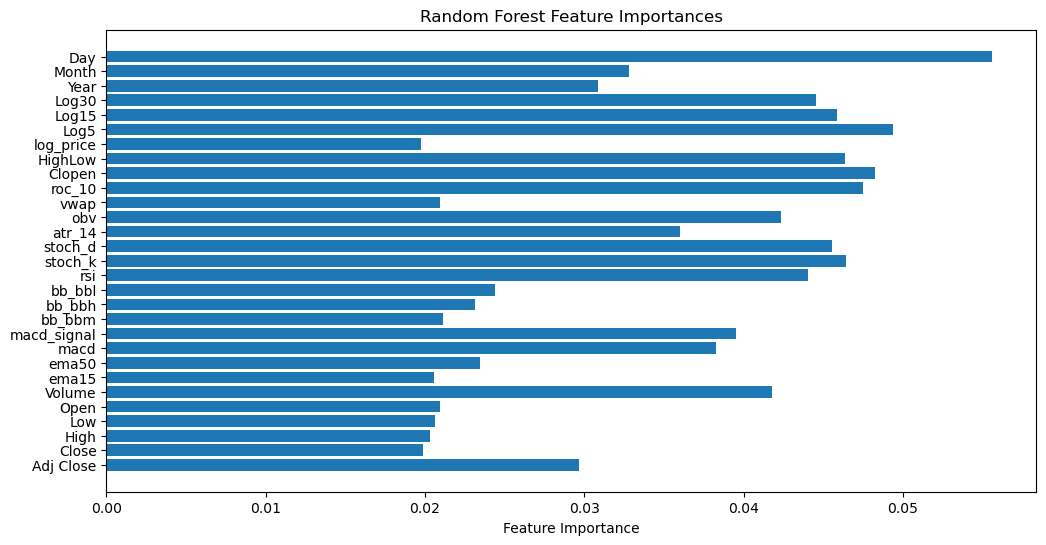

In [8]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,      
    max_depth=20,
    max_features='sqrt',      
    min_samples_leaf=4,
    min_samples_split=10,
)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (RF): {test_accuracy}")

train_y_pred = rf_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, train_y_pred)
print(f"Train Accuracy (RF): {train_accuracy}")

importances = rf_classifier.feature_importances_
features = X.columns
plt.figure(figsize=(12, 6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()

100, 20, sqrt, 4, 10
Test Accuracy (RF): 0.5752187411797911
Train Accuracy (RF): 0.8932648064641054

After removing the days:
Test Accuracy: 0.5212768052300967
Train Accuracy: 0.7544869564836877

200, none, sqrt, 1, 2
Test Accuracy: 0.5783431463284957
Train Accuracy: 1.0

In [46]:
stock_data = pd.read_csv('./merged_data.csv')
stock_data = stock_data.dropna()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month'] = stock_data['Date'].dt.month
stock_data['Day'] = stock_data['Date'].dt.day
stock_data = stock_data.drop('Date', axis=1)
stock_data = stock_data.drop('Symbol', axis=1)
stock_data = stock_data.drop('Ticker', axis=1)
stock_data = stock_data.drop('Target', axis=1)

X = stock_data.drop(['Pct_Change'], axis=1)
y = stock_data['Pct_Change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [52]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

threshold = 0.005  # 0.5%

profitable_predictions = (y_pred > threshold)
num_trades = profitable_predictions.sum()
returns = y_test[profitable_predictions]
quants = np.quantile(returns, [0, 0.05, 0.5, .95, 1])
normalized_returns = []
for i in returns:
    if i > quants[1] and i < quants[3]:
        normalized_returns.append(i)

avg_actual_return = y_test[profitable_predictions].mean()
avg_selected_returns = sum(normalized_returns) / len(normalized_returns)

print(f"Number of selected trades: {num_trades}")
print(f"Number of middle 90% trades: {len(normalized_returns)}")
print(f"Avg return on all selected trades: {avg_actual_return:.4f}")
print(f"Avg return on filtered selected trades: {avg_selected_returns:.4f}")
print(y_test[profitable_predictions].max())
print(y_test[profitable_predictions].min())

MSE: 0.0003916357149418419
MAE: 0.0130
RMSE: 0.0198
R² Score: 0.0014
Number of selected trades: 1011
Number of middle 90% trades: 909
Avg return on all selected trades: 0.0104
Avg return on filtered selected trades: 0.0112
0.3076241444302586
-0.3481308819893823


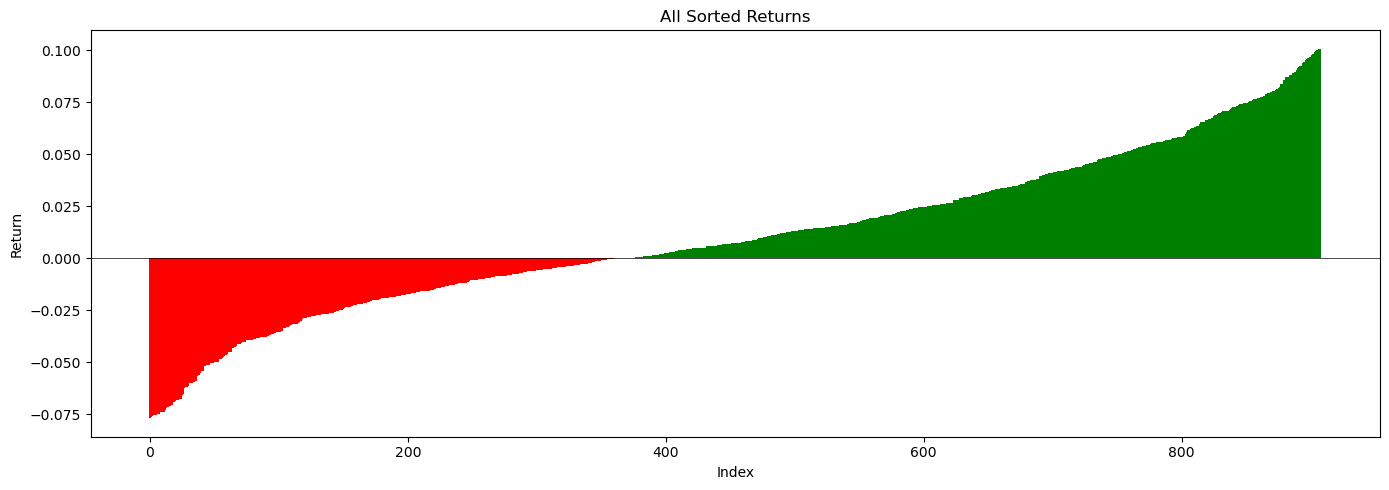

In [53]:
sorted_indices = np.argsort(normalized_returns)
sorted_returns = np.array(normalized_returns)[sorted_indices]
# Assign colors based on positive or negative value
colors = ['green' if val >= 0 else 'red' for val in sorted_returns]

# Plot
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(sorted_returns)), sorted_returns, color=colors, width=1.0)
plt.axhline(0, color='black', linewidth=0.5)
plt.title('All Sorted Returns')
plt.xlabel('Index')
plt.ylabel('Return')
plt.tight_layout()
plt.show()

In [54]:
threshold = -0.005  # 0.5%

loss_predictions = (y_pred < threshold)
num_trades = loss_predictions.sum()
returns = y_test[loss_predictions]
quants = np.quantile(returns, [0, 0.05, 0.5, .95, 1])
normalized_returns = []
for i in returns:
    if i > quants[1] and i < quants[3]:
        normalized_returns.append(i)

avg_actual_return = y_test[loss_predictions].mean()
avg_selected_returns = sum(normalized_returns) / len(normalized_returns)

print(f"Number of selected losing trades: {num_trades}")
print(f"Number of middle 90% trades: {len(normalized_returns)}")
print(f"Avg return on all selected trades: {avg_actual_return:.4f}")
print(f"Avg return on filtered selected trades: {avg_selected_returns:.4f}")
print(y_test[loss_predictions].max())
print(y_test[loss_predictions].min())

Number of selected losing trades: 176
Number of middle 90% trades: 158
Avg return on all selected trades: -0.0067
Avg return on filtered selected trades: -0.0074
0.1745894996580947
-0.1888079307404959


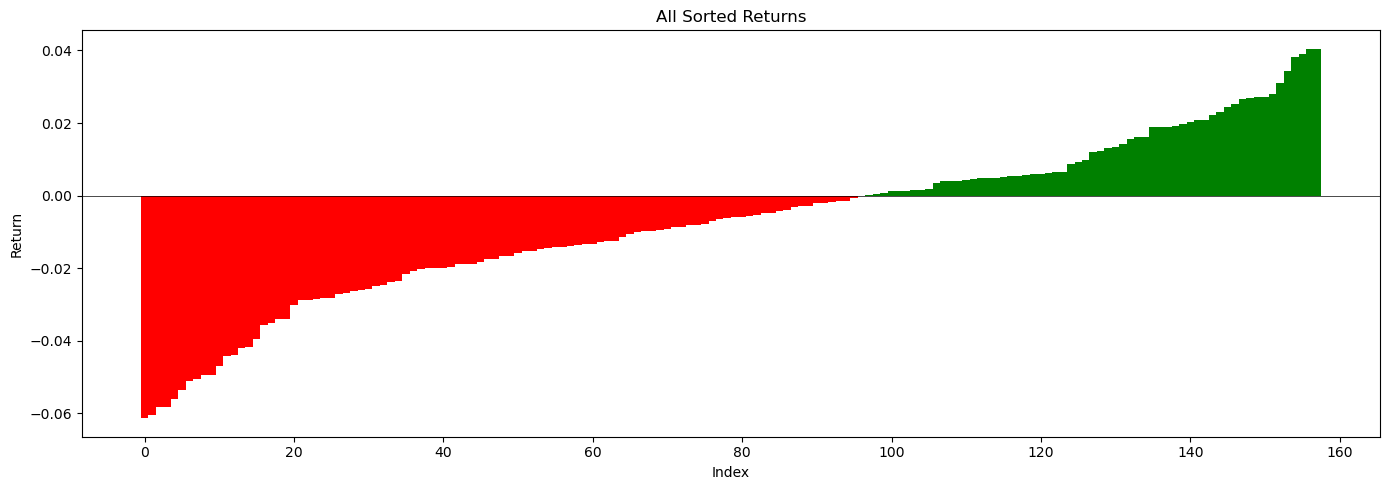

In [55]:
sorted_indices = np.argsort(normalized_returns)
sorted_returns = np.array(normalized_returns)[sorted_indices]
# Assign colors based on positive or negative value
colors = ['green' if val >= 0 else 'red' for val in sorted_returns]

# Plot
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(sorted_returns)), sorted_returns, color=colors, width=1.0)
plt.axhline(0, color='black', linewidth=0.5)
plt.title('All Sorted Returns')
plt.xlabel('Index')
plt.ylabel('Return')
plt.tight_layout()
plt.show()

In [14]:
print(len(y_pred[(y_pred > 0)]))
print(len(y_pred[(y_pred < 0)]))

127708
24598


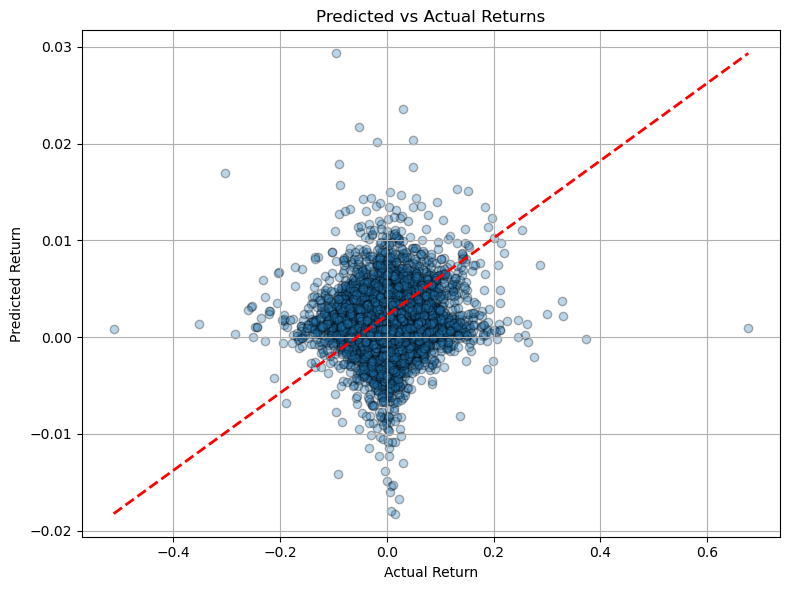

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'r--', lw=2)  # reference line
plt.xlabel("Actual Return")
plt.ylabel("Predicted Return")
plt.title("Predicted vs Actual Returns")
plt.grid(True)
plt.tight_layout()
plt.show()

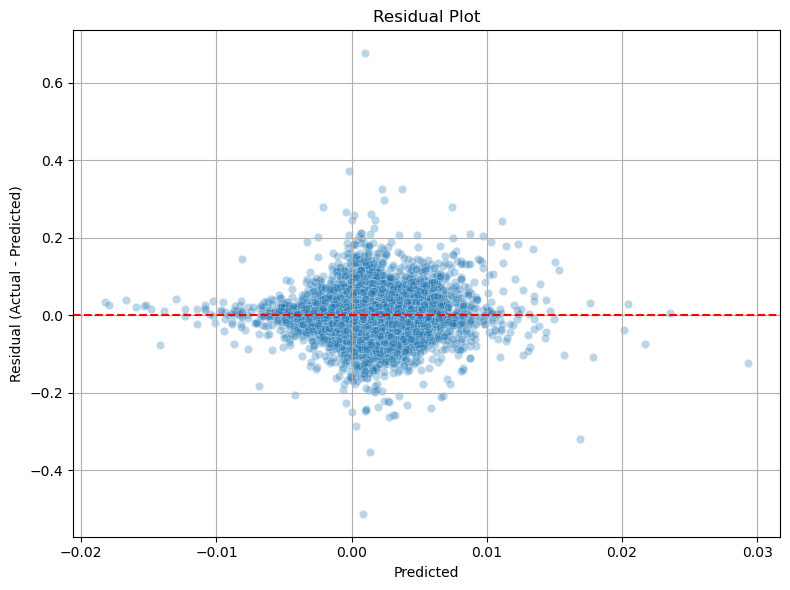

In [16]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
coefs = reg.coef_
feature_names = X_train.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coef_df.head(10))

        Feature  Coefficient  Abs_Coefficient
20       Clopen    -0.033509         0.033509
21      HighLow     0.015907         0.015907
23         Log5    -0.007208         0.007208
25        Log30    -0.004859         0.004859
3           Low     0.000657         0.000657
24        Log15    -0.000522         0.000522
1         Close    -0.000515         0.000515
4          Open    -0.000497         0.000497
8          macd     0.000472         0.000472
9   macd_signal    -0.000430         0.000430


In [18]:
top_n = 10
top_features = coef_df['Feature'].head(top_n).values
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

In [19]:
lr_top = LinearRegression()
lr_top.fit(X_train_top, y_train)
y_pred_top = lr_top.predict(X_test_top)

In [20]:
mse = mean_squared_error(y_test, y_pred_top)
mae = mean_absolute_error(y_test, y_pred_top)
rmse = mean_squared_error(y_test, y_pred_top, squared=False)
r2 = r2_score(y_test, y_pred_top)
print(f"MSE: {mse}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

threshold = 0.005  # 0.5%

profitable_predictions = (y_pred_top > threshold)
num_trades = profitable_predictions.sum()
returns = y_test[profitable_predictions]
quants = np.quantile(returns, [0, 0.05, 0.5, .95, 1])
normalized_returns = []
for i in returns:
    if i > quants[1] and i < quants[3]:
        normalized_returns.append(i)

avg_actual_return = y_test[profitable_predictions].mean()
avg_selected_returns = sum(normalized_returns) / len(normalized_returns)

print(f"Number of selected trades: {num_trades}")
print(f"Number of middle 90% trades: {len(normalized_returns)}")
print(f"Avg return on all selected trades: {avg_actual_return:.4f}")
print(f"Avg return on filtered selected trades: {avg_selected_returns:.4f}")
print(y_test[profitable_predictions].max())
print(y_test[profitable_predictions].min())

MSE: 0.0003987194594859367
MAE: 0.0130
RMSE: 0.0200
R² Score: 0.0017
Number of selected trades: 339
Number of middle 90% trades: 305
Avg return on all selected trades: 0.0159
Avg return on filtered selected trades: 0.0156
0.2866160962401872
-0.3029018875910584


Now to predict the last 5 months of a stock and show performance

In [56]:
stock_data = pd.read_csv('./merged_data.csv')
stock_data = stock_data.dropna()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month'] = stock_data['Date'].dt.month
stock_data['Day'] = stock_data['Date'].dt.day
stock_data = stock_data.drop('Date', axis=1)
stock_data = stock_data.drop('Symbol', axis=1)
stock_data = stock_data.drop('Ticker', axis=1)
stock_data = stock_data.drop('Target', axis=1)

X = stock_data.drop(['Pct_Change'], axis=1)
y = stock_data['Pct_Change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

MSE: 0.00030862578098506176


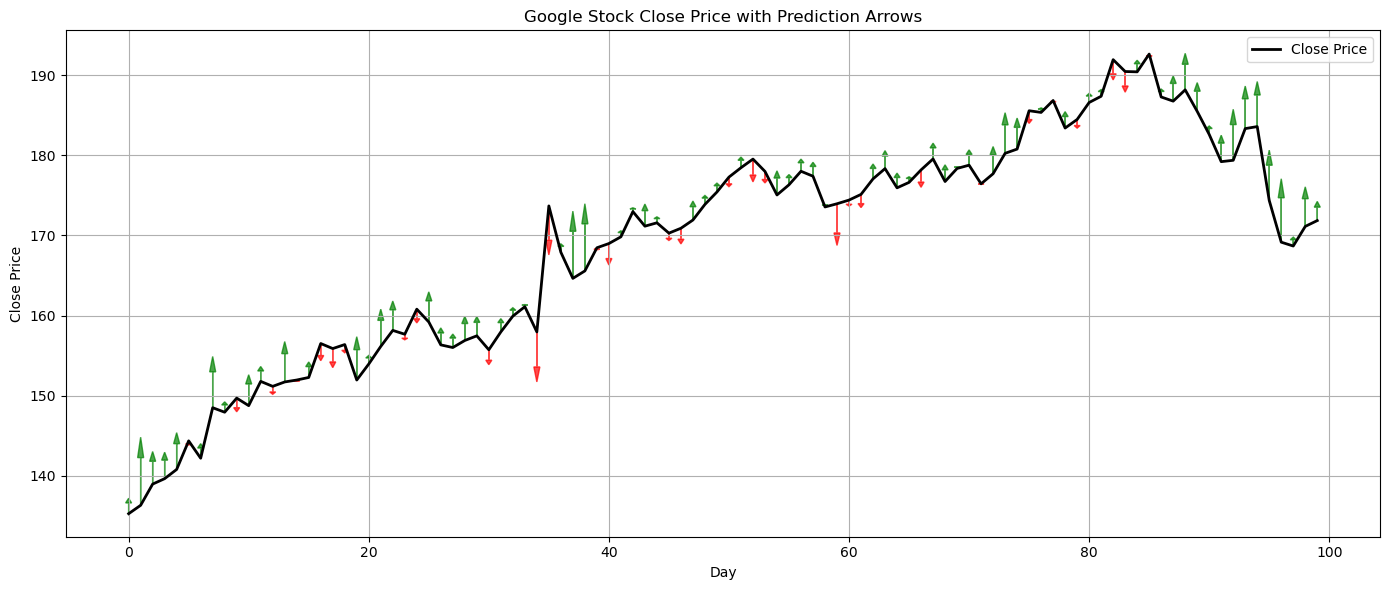

In [57]:
test_stock_data = pd.read_csv('./clean_data/GOOG.csv')
test_stock_data = test_stock_data.dropna()
test_stock_data['Date'] = pd.to_datetime(test_stock_data['Date'])
test_stock_data['Year'] = test_stock_data['Date'].dt.year
test_stock_data['Month'] = test_stock_data['Date'].dt.month
test_stock_data['Day'] = test_stock_data['Date'].dt.day
test_stock_data = test_stock_data.drop('Date', axis=1)
test_stock_data = test_stock_data.drop('Symbol', axis=1)
test_stock_data = test_stock_data.drop('Target', axis=1)
reg = LinearRegression()
reg.fit(X_train, y_train)

X_test = test_stock_data.drop(['Pct_Change'], axis=1)
y_test = test_stock_data['Pct_Change'][-200:-100]

y_pred = reg.predict(X_test[-200:-100])
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")


x = np.arange(100)  # x-axis as index
y = X_test['Close'][-200:-100].to_numpy() # closing prices
plt.figure(figsize=(14, 6))
plt.plot(x, y, label='Close Price', color='black', linewidth=2)

# Add arrows
for i in range(len(x)):
    arrow_length = y_pred[i] * 5000  # Scale to make arrows visible
    color = 'green' if y_pred[i] > 0 else 'red'
    
    plt.arrow(
        x[i], y[i],
        0, arrow_length,  # dx = 0, dy = scaled prediction
        color=color,
        head_width=0.5,
        head_length=abs(arrow_length) * 0.3,
        length_includes_head=True,
        alpha=0.7
    )

plt.title('Google Stock Close Price with Prediction Arrows')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

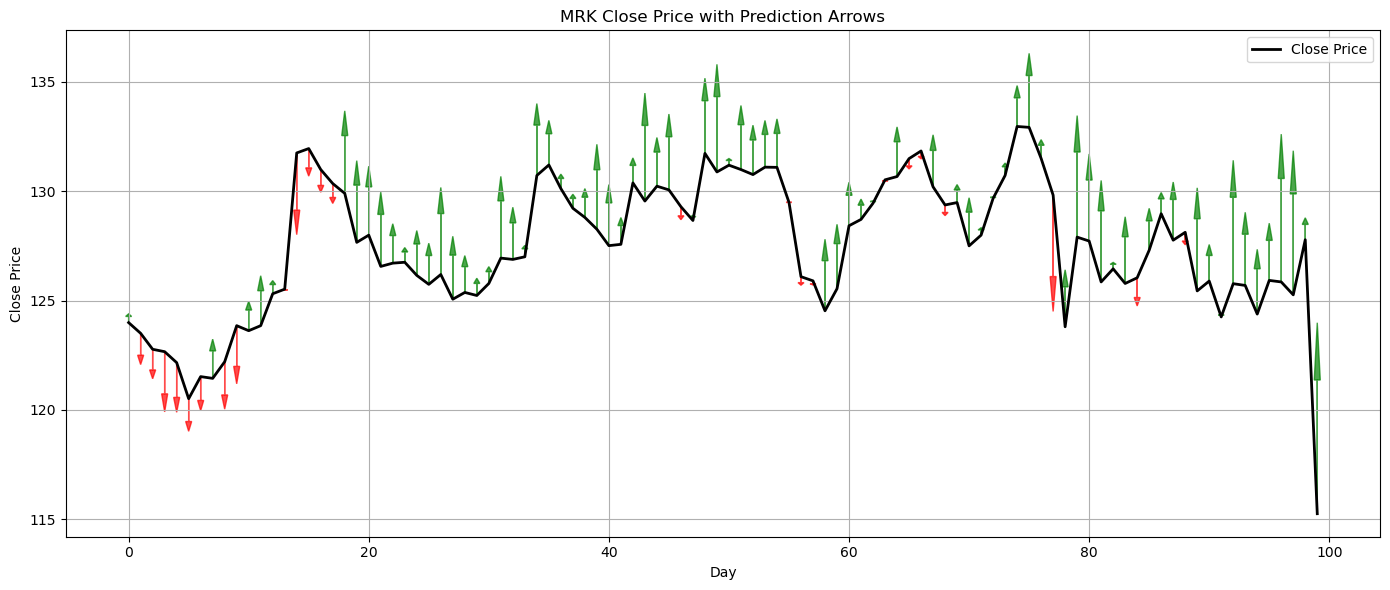

In [58]:
test_stock_data = pd.read_csv('./clean_data/MRK.csv')
test_stock_data = test_stock_data.dropna()
test_stock_data['Date'] = pd.to_datetime(test_stock_data['Date'])
test_stock_data['Year'] = test_stock_data['Date'].dt.year
test_stock_data['Month'] = test_stock_data['Date'].dt.month
test_stock_data['Day'] = test_stock_data['Date'].dt.day
test_stock_data = test_stock_data.drop('Date', axis=1)
test_stock_data = test_stock_data.drop('Symbol', axis=1)
test_stock_data = test_stock_data.drop('Target', axis=1)
reg = LinearRegression()
reg.fit(X_train, y_train)

X_test = test_stock_data.drop(['Pct_Change'], axis=1)
y_test = test_stock_data['Pct_Change'][-200:-100]

y_pred = reg.predict(X_test[-200:-100])

x = np.arange(100)  # x-axis as index
y = X_test['Close'][-200:-100].to_numpy() # closing prices
plt.figure(figsize=(14, 6))
plt.plot(x, y, label='Close Price', color='black', linewidth=2)

# Add arrows
for i in range(len(x)):
    arrow_length = y_pred[i] * 5000  # Scale to make arrows visible
    color = 'green' if y_pred[i] > 0 else 'red'
    
    plt.arrow(
        x[i], y[i],
        0, arrow_length,  # dx = 0, dy = scaled prediction
        color=color,
        head_width=0.5,
        head_length=abs(arrow_length) * 0.3,
        length_includes_head=True,
        alpha=0.7
    )

plt.title('MRK Close Price with Prediction Arrows')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

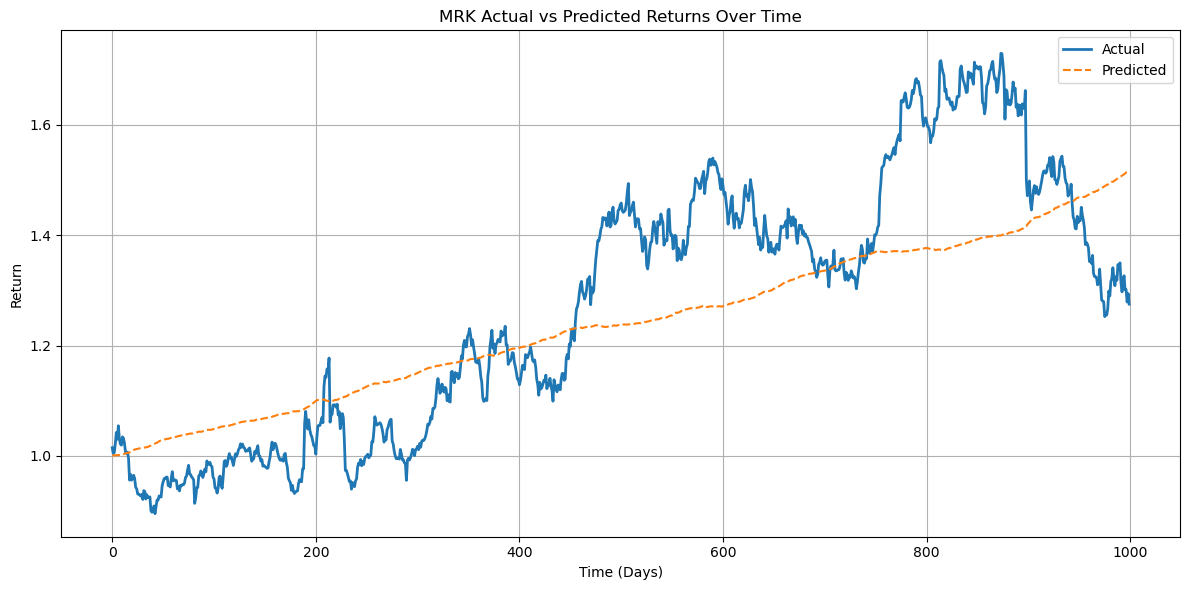

In [61]:
test_stock_data = pd.read_csv('./clean_data/MRK.csv')
test_stock_data = test_stock_data.dropna()
test_stock_data['Date'] = pd.to_datetime(test_stock_data['Date'])
test_stock_data['Year'] = test_stock_data['Date'].dt.year
test_stock_data['Month'] = test_stock_data['Date'].dt.month
test_stock_data['Day'] = test_stock_data['Date'].dt.day
test_stock_data = test_stock_data.drop('Date', axis=1)
test_stock_data = test_stock_data.drop('Symbol', axis=1)
test_stock_data = test_stock_data.drop('Target', axis=1)
reg = LinearRegression()
reg.fit(X_train, y_train)

X_test = test_stock_data.drop(['Pct_Change'], axis=1)

y_test = test_stock_data['Pct_Change'][-1000:]

y_pred = reg.predict(X_test[-1000:])

actual_cumulative = (1 + y_test).cumprod()
predicted_cumulative = (1 + y_pred).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(actual_cumulative.values, label="Actual", linewidth=2)
plt.plot(predicted_cumulative, label="Predicted", linestyle='--')
plt.title("MRK Actual vs Predicted Returns Over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

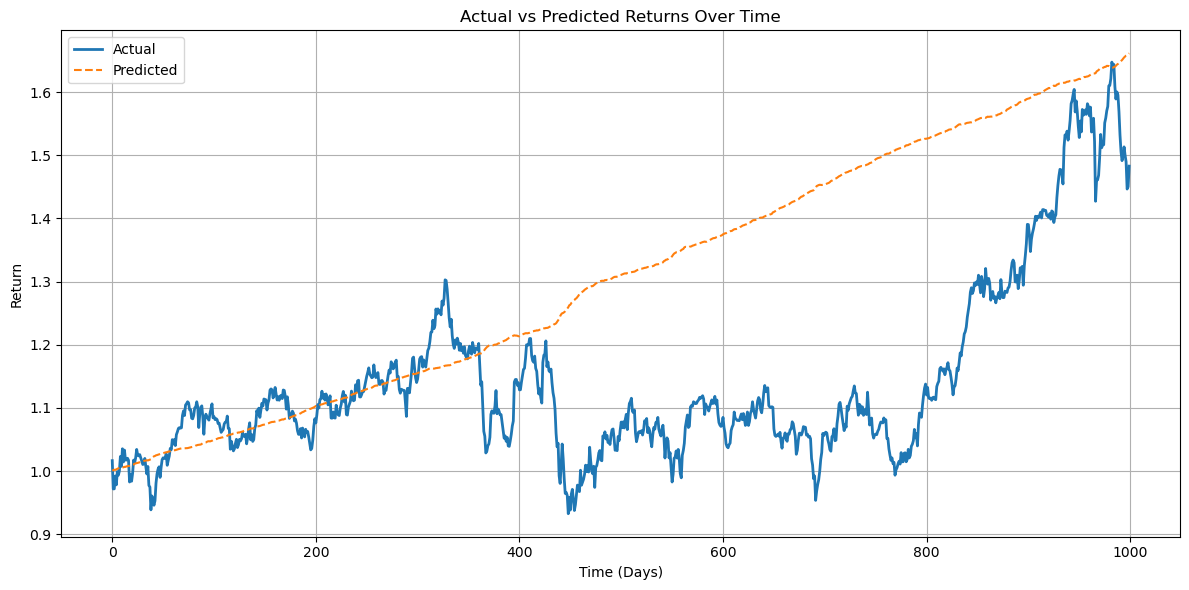

In [25]:
test_stock_data = pd.read_csv('./clean_data/PEG.csv')
test_stock_data = test_stock_data.dropna()
test_stock_data['Date'] = pd.to_datetime(test_stock_data['Date'])
test_stock_data['Year'] = test_stock_data['Date'].dt.year
test_stock_data['Month'] = test_stock_data['Date'].dt.month
test_stock_data['Day'] = test_stock_data['Date'].dt.day
test_stock_data = test_stock_data.drop('Date', axis=1)
test_stock_data = test_stock_data.drop('Symbol', axis=1)
test_stock_data = test_stock_data.drop('Target', axis=1)
reg = LinearRegression()
reg.fit(X_train, y_train)

X_test = test_stock_data.drop(['Pct_Change'], axis=1)

y_test = test_stock_data['Pct_Change'][-1000:]

y_pred = reg.predict(X_test[-1000:])

actual_cumulative = (1 + y_test).cumprod()
predicted_cumulative = (1 + y_pred).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(actual_cumulative.values, label="Actual", linewidth=2)
plt.plot(predicted_cumulative, label="Predicted", linestyle='--')
plt.title("Actual vs Predicted Returns Over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

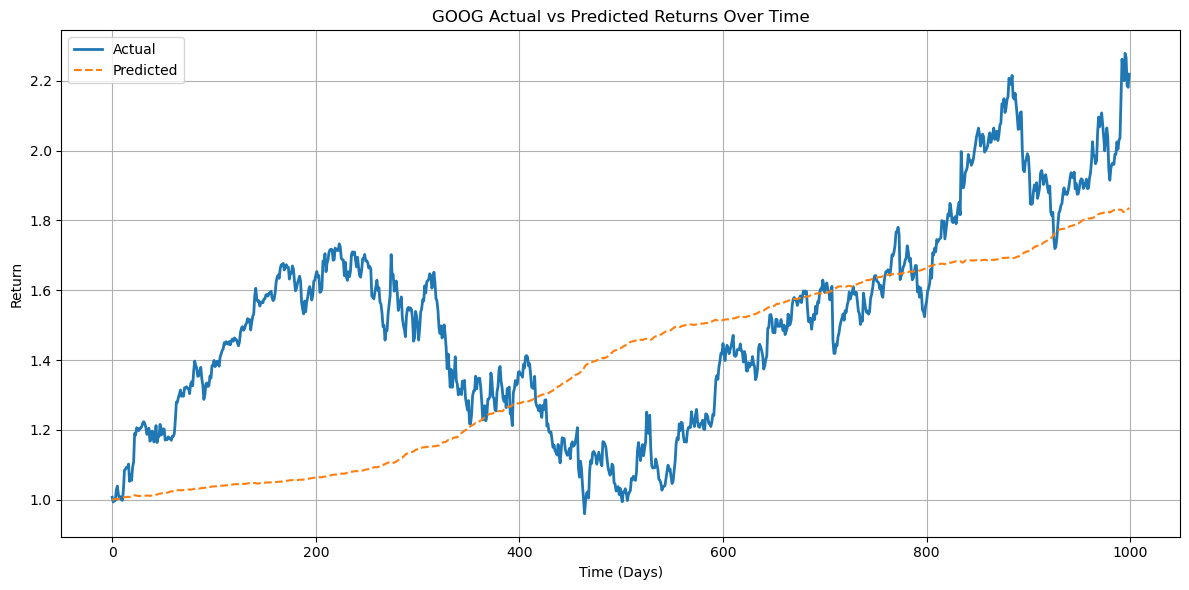

In [60]:
test_stock_data = pd.read_csv('./clean_data/GOOG.csv')
test_stock_data = test_stock_data.dropna()
test_stock_data['Date'] = pd.to_datetime(test_stock_data['Date'])
test_stock_data['Year'] = test_stock_data['Date'].dt.year
test_stock_data['Month'] = test_stock_data['Date'].dt.month
test_stock_data['Day'] = test_stock_data['Date'].dt.day
test_stock_data = test_stock_data.drop('Date', axis=1)
test_stock_data = test_stock_data.drop('Symbol', axis=1)
test_stock_data = test_stock_data.drop('Target', axis=1)
reg = LinearRegression()
reg.fit(X_train, y_train)

X_test = test_stock_data.drop(['Pct_Change'], axis=1)

y_test = test_stock_data['Pct_Change'][-1000:]

y_pred = reg.predict(X_test[-1000:])

actual_cumulative = (1 + y_test).cumprod()
predicted_cumulative = (1 + y_pred).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(actual_cumulative.values, label="Actual", linewidth=2)
plt.plot(predicted_cumulative, label="Predicted", linestyle='--')
plt.title("GOOG Actual vs Predicted Returns Over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [87]:
stock_data = pd.read_csv('./merged_data.csv')
stock_data = stock_data.dropna()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month'] = stock_data['Date'].dt.month
stock_data['Day'] = stock_data['Date'].dt.day
stock_data = stock_data.drop('Date', axis=1)
stock_data = stock_data.drop('Symbol', axis=1)
stock_data = stock_data.drop('Ticker', axis=1)
stock_data = stock_data.drop('Target', axis=1)

X = stock_data.drop(['Pct_Change'], axis=1)
y = stock_data['Pct_Change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

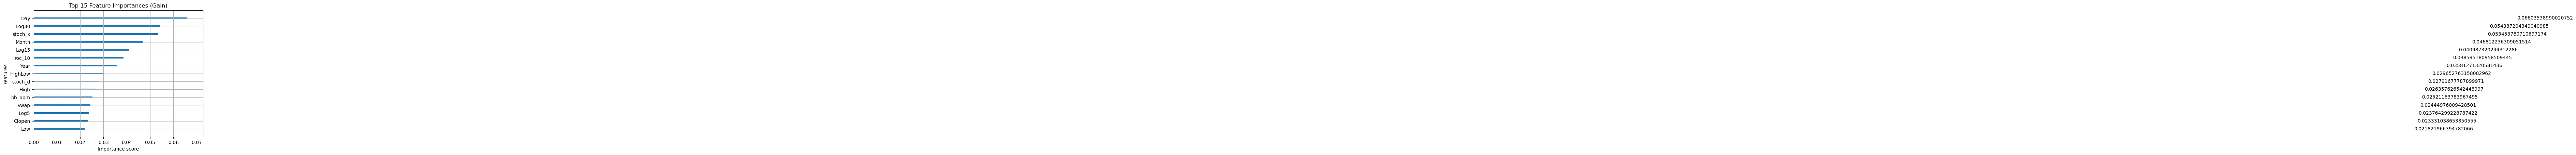

In [88]:
plot_importance(xgb, importance_type='gain', max_num_features=15)
plt.title("Top 15 Feature Importances (Gain)")
plt.show()

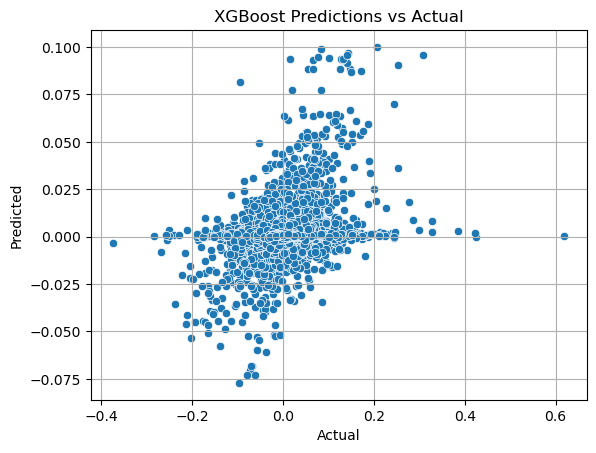

In [89]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost Predictions vs Actual")
plt.grid(True)
plt.show()

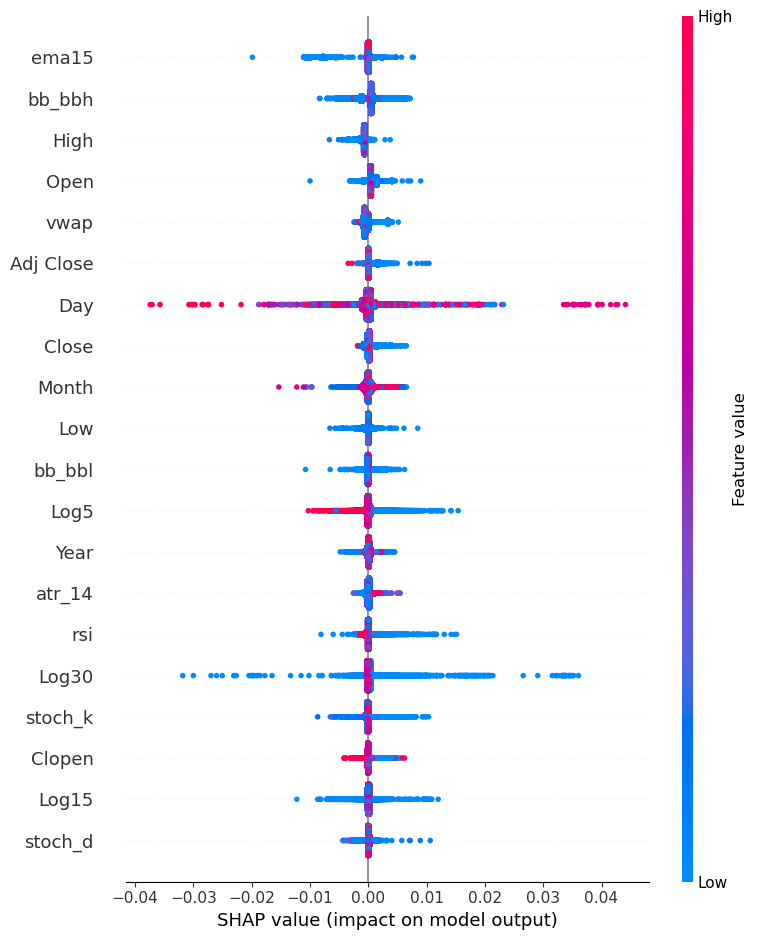

In [73]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

In [90]:
scores = cross_val_score(xgb, X, y, cv=5, scoring='neg_mean_squared_error')
print("RMSE:", (-scores.mean())**0.5)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

RMSE: 0.019601431851785586
MAE: 0.0129
R² Score: 0.0421


In [62]:
stock_data = pd.read_csv('./merged_data.csv')
stock_data = stock_data.dropna()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
last_year_data = stock_data[stock_data['Date'] >= '2024-04-01']
last_year_data = last_year_data.drop('Ticker', axis=1)

X_last_year = last_year_data.drop(['Pct_Change', 'Date', 'Target', 'Symbol'], axis=1)
y_last_year = last_year_data['Pct_Change']  # actual % change (daily return)

X_train, X_test, y_train, y_test = train_test_split(X_last_year, y_last_year, test_size=0.25)
reg = LinearRegression()
reg.fit(X_train, y_train)

predicted_returns = reg.predict(X_last_year)

In [63]:
initial_cash = 10000
threshold = 0.003
portfolio_history = {}
symbols = last_year_data['Symbol'].unique()
for symbol in symbols:
    symbol_df = last_year_data[last_year_data['Symbol'] == symbol].copy()
    X = symbol_df.drop(['Date', 'Symbol', 'Target', 'Pct_Change'], axis=1)
    y = symbol_df['Pct_Change']
    dates = symbol_df['Date'].values

    preds = reg.predict(X)

    cash = initial_cash
    returns = []

    for pred, actual in zip(preds, y):
        if pred > threshold:
            cash *= (1 + actual)
        returns.append(cash)

    portfolio_history[symbol] = (dates, returns)

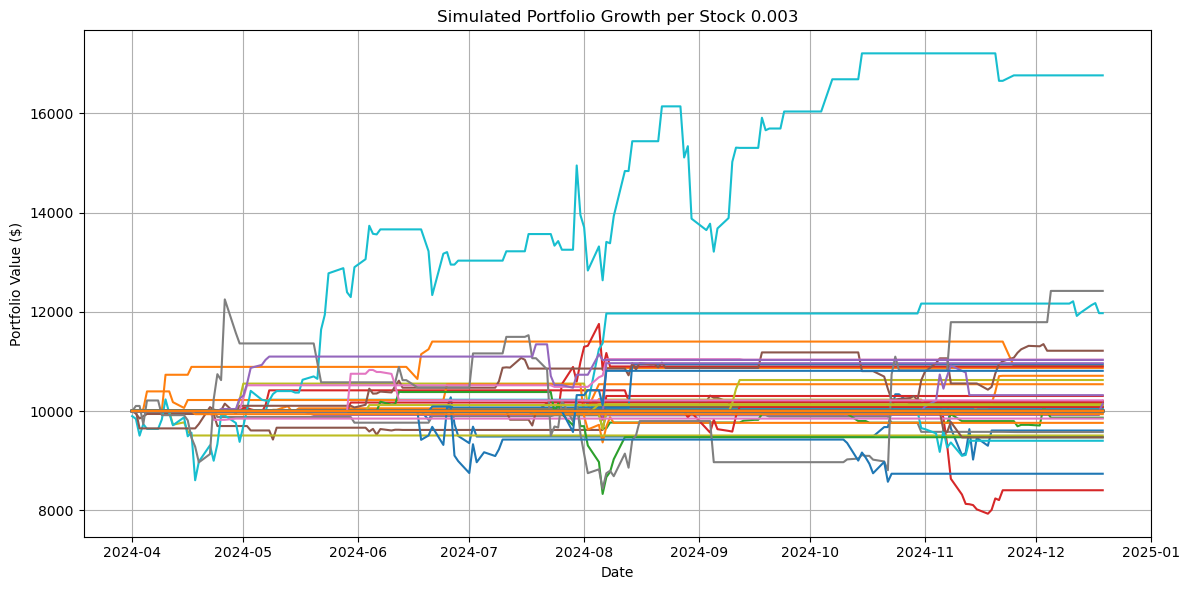

In [64]:
plt.figure(figsize=(12, 6))
for symbol, (dates, returns) in portfolio_history.items():
    plt.plot(dates, returns, label=symbol)

plt.title("Simulated Portfolio Growth per Stock 0.003")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
successes = 0
losses = 0
no_trades = 0
total_change = 0
for symbol, (dates, returns) in portfolio_history.items():
    total_change += returns[-1] - 10000
    if returns[-1] > 10000:
        successes += 1
    elif returns[-1] < 10000:
        losses += 1
    elif returns[-1] == 10000:
        no_trades += 1
print(successes, losses, no_trades, len(portfolio_history.items()))
print(total_change)

32 17 123 172
17850.687185385148


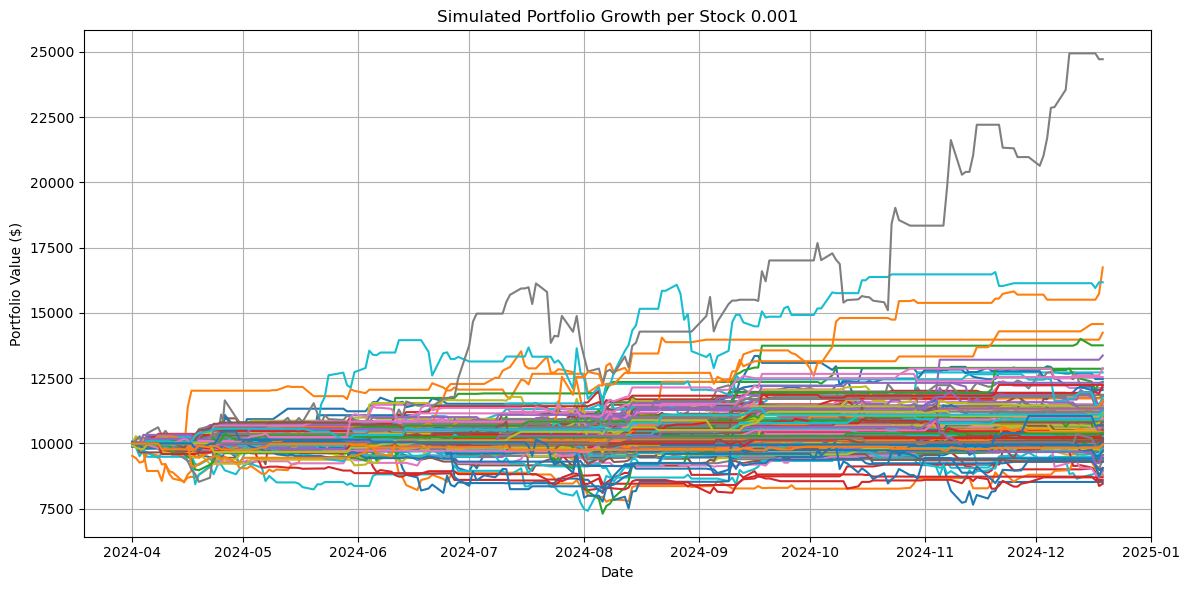

134 38 0 172
131612.50549812135


In [66]:
initial_cash = 10000
threshold = 0.001
portfolio_history = {}
symbols = last_year_data['Symbol'].unique()
for symbol in symbols:
    symbol_df = last_year_data[last_year_data['Symbol'] == symbol].copy()
    X = symbol_df.drop(['Date', 'Symbol', 'Target', 'Pct_Change'], axis=1)
    y = symbol_df['Pct_Change']
    dates = symbol_df['Date'].values

    preds = reg.predict(X)

    cash = initial_cash
    returns = []

    for pred, actual in zip(preds, y):
        if pred > threshold:
            cash *= (1 + actual)
        returns.append(cash)

    portfolio_history[symbol] = (dates, returns)
plt.figure(figsize=(12, 6))
for symbol, (dates, returns) in portfolio_history.items():
    plt.plot(dates, returns, label=symbol)

plt.title("Simulated Portfolio Growth per Stock 0.001")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()
successes = 0
losses = 0
no_trades = 0
total_change = 0
for symbol, (dates, returns) in portfolio_history.items():
    total_change += returns[-1] - 10000
    if returns[-1] > 10000:
        successes += 1
    elif returns[-1] < 10000:
        losses += 1
    elif returns[-1] == 10000:
        no_trades += 1
print(successes, losses, no_trades, len(portfolio_history.items()))
print(total_change)

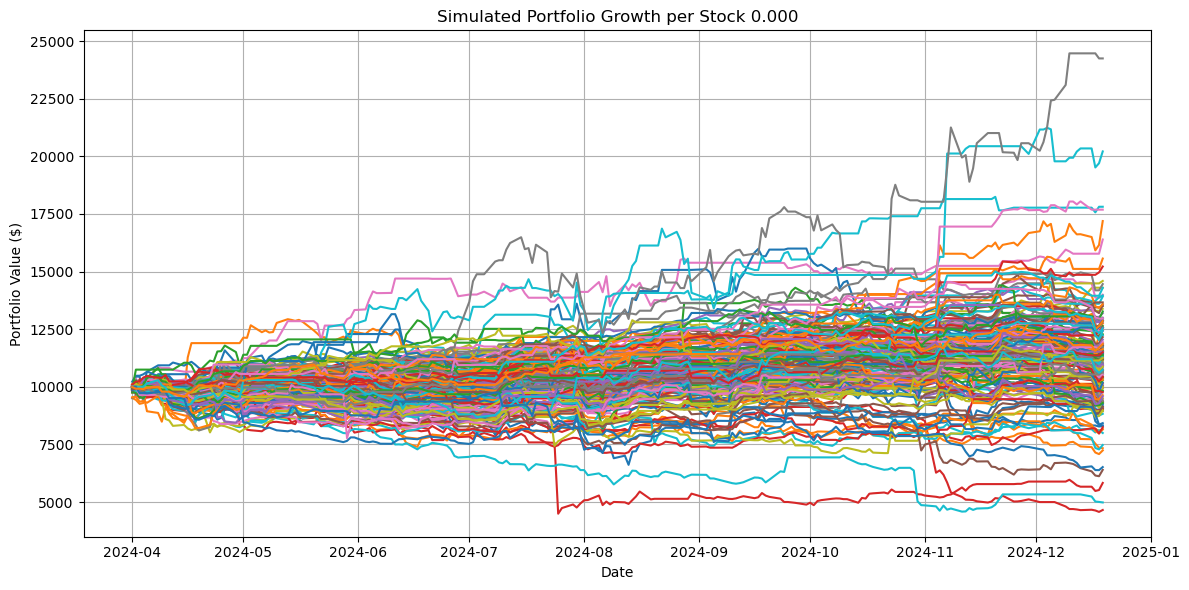

127 45 0 172
211656.4934964159


In [67]:
initial_cash = 10000
threshold = 0.000
portfolio_history = {}
symbols = last_year_data['Symbol'].unique()
for symbol in symbols:
    symbol_df = last_year_data[last_year_data['Symbol'] == symbol].copy()
    X = symbol_df.drop(['Date', 'Symbol', 'Target', 'Pct_Change'], axis=1)
    y = symbol_df['Pct_Change']
    dates = symbol_df['Date'].values

    preds = reg.predict(X)

    cash = initial_cash
    returns = []

    for pred, actual in zip(preds, y):
        if pred > threshold:
            cash *= (1 + actual)
        returns.append(cash)

    portfolio_history[symbol] = (dates, returns)
plt.figure(figsize=(12, 6))
for symbol, (dates, returns) in portfolio_history.items():
    plt.plot(dates, returns, label=symbol)

plt.title("Simulated Portfolio Growth per Stock 0.000")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()
successes = 0
losses = 0
no_trades = 0
total_change = 0
for symbol, (dates, returns) in portfolio_history.items():
    total_change += returns[-1] - 10000
    if returns[-1] > 10000:
        successes += 1
    elif returns[-1] < 10000:
        losses += 1
    elif returns[-1] == 10000:
        no_trades += 1
print(successes, losses, no_trades, len(portfolio_history.items()))
print(total_change)

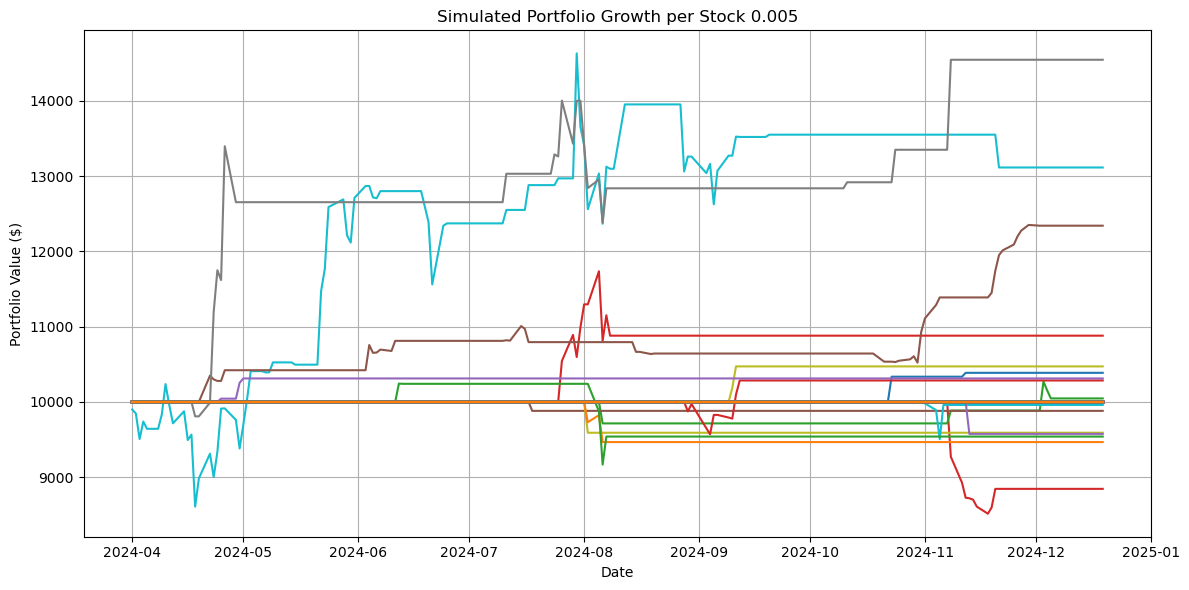

9 7 156 172
9244.413401804168


In [69]:
initial_cash = 10000
threshold = 0.005
portfolio_history = {}
symbols = last_year_data['Symbol'].unique()
for symbol in symbols:
    symbol_df = last_year_data[last_year_data['Symbol'] == symbol].copy()
    X = symbol_df.drop(['Date', 'Symbol', 'Target', 'Pct_Change'], axis=1)
    y = symbol_df['Pct_Change']
    dates = symbol_df['Date'].values

    preds = reg.predict(X)

    cash = initial_cash
    returns = []

    for pred, actual in zip(preds, y):
        if pred > threshold:
            cash *= (1 + actual)
        returns.append(cash)

    portfolio_history[symbol] = (dates, returns)
plt.figure(figsize=(12, 6))
for symbol, (dates, returns) in portfolio_history.items():
    plt.plot(dates, returns, label=symbol)

plt.title("Simulated Portfolio Growth per Stock 0.005")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()
successes = 0
losses = 0
no_trades = 0
total_change = 0
for symbol, (dates, returns) in portfolio_history.items():
    total_change += returns[-1] - 10000
    if returns[-1] > 10000:
        successes += 1
    elif returns[-1] < 10000:
        losses += 1
    elif returns[-1] == 10000:
        no_trades += 1
print(successes, losses, no_trades, len(portfolio_history.items()))
print(total_change)

In [39]:
stock_data = pd.read_csv('./merged_data.csv')
stock_data = stock_data.dropna()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month'] = stock_data['Date'].dt.month
stock_data['Day'] = stock_data['Date'].dt.day
stock_data = stock_data.drop('Date', axis=1)
stock_data = stock_data.drop('Symbol', axis=1)
stock_data = stock_data.drop('Ticker', axis=1)
stock_data = stock_data.drop('Target', axis=1)

X = stock_data.drop(['Pct_Change'], axis=1)
y = stock_data['Pct_Change']

GOOG_data = pd.read_csv('./clean_data/GOOG.csv')
GOOG_data['Date'] = pd.to_datetime(GOOG_data['Date'])
GOOG_data['Year'] = GOOG_data['Date'].dt.year
GOOG_data['Month'] = GOOG_data['Date'].dt.month
GOOG_data['Day'] = GOOG_data['Date'].dt.day
GOOG_data = GOOG_data.drop('Target', axis=1)
X_test = GOOG_data.drop('Date', axis=1)
X_test = X_test.drop('Symbol', axis=1)
X_test = X_test.drop('Pct_Change', axis=1)
X_test = X_test[-1000:]
y_test = GOOG_data['Pct_Change'][-1000:]

reg = LinearRegression()
reg.fit(X, y)

y_pred = reg.predict(X_test)

y_pred_series = pd.Series(y_pred, index=X_test.index, name='Prediction')
GOOG = pd.concat([X_test, y_pred_series], axis=1)


In [40]:
GOOG.head()

,Adj Close,Close,High,Low,Open,Volume,ema15,ema50,macd,macd_signal,...,Clopen,HighLow,log_price,Log5,Log15,Log30,Year,Month,Day,Prediction
2768,87.280396,87.594002,87.946503,86.771004,86.771004,20238000.0,87.732908,86.013080,0.057685,0.309203,...,1.009485,1.013547,4.472713,0.011193,-0.018241,-0.010375,2020,12,31,0.000552
2769,86.102631,86.412003,88.032501,85.392502,87.876999,38038000.0,87.567794,86.028724,-0.045457,0.238271,...,0.983329,1.030916,4.459127,-0.006120,-0.026883,-0.010670,2021,1,4,0.000142
2770,86.734360,87.045998,87.383499,85.900749,86.250000,22906000.0,87.502570,86.068617,-0.075174,0.175582,...,1.009229,1.017261,4.466437,-0.020001,-0.023194,-0.013125,2021,1,5,0.000465
2771,86.453857,86.764503,87.400002,84.949997,85.131500,52042000.0,87.410312,86.095907,-0.120055,0.116455,...,1.019182,1.028841,4.463198,-0.013412,-0.014173,-0.003968,2021,1,6,0.000207
2772,89.042557,89.362503,89.419998,86.852501,87.002998,45300000.0,87.654336,86.224008,0.053398,0.103843,...,1.027120,1.029562,4.492701,0.027069,0.010959,0.029751,2021,1,7,0.000444


In [41]:
class Strat(Strategy):

    def init(self):
        self.pred = self.data.df['Prediction'].values

    def next(self):
        i = len(self.data.Close) - 1
        prediction = self.pred[i]
        threshold = 0.0005

        if prediction > threshold and not self.position:
            self.buy()
        elif prediction < -threshold and self.position:
            self.position.close()


bt = Backtest(GOOG, Strat,
              cash=10000, commission=.002,
              exclusive_orders=True)

output = bt.run()
bt.plot()

/var/folders/8q/pd8bhfh923x7_5hc541qy_8c0000gn/T/ipykernel_76783/1924267558.py:17: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(GOOG, Strat,


Backtest.run:   0%|          | 0/999 [00:00<?, ?bar/s]

GridPlot(id='p1303', ...)